In [1]:
import os
import sys
sys.path.append('../..')

import pyedflib
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal
from imp import reload
import pandas as pd
import pywt
import readFiles
import databasePreparation
import preProcessing
import readEogertData
import math
from scipy import ndimage, misc
import json
import string
import neurokit2 as nk
import mne
import eeg_label
import evaluationUtils

from visualization import plotEogElectrodesSignal, plotVertHorEOG, plotSaccadeSpanInSignal, plotTransformAndPeaks, plotSaccadeGTSpanInSignal, plotSaccadeIntervals
from classificationUtils import peaksToBinary, peaksBinarySaccadeAnalysis, peaksBinaryToString, countEyeMovements, findPeaks
from evaluationUtils import countCorrectDetected, calculatePrecision, calculateRecall

In [2]:
# Reading the signals from the EDF file

fileName = 'C:/Users/Ricardo/source/enac-eog-analysis/src/labelAnnotation/EOGLabel-main/eegDataSet.edf'
channelsOfInterest = [64, 65, 66, 67, 68, 69]

# 64 - EXG1 = EOG D
# 65 - EXG2 = EOG G
# 66 - EXG3 = EOG D INTERNAL
# 67 - EXG4 = EOG G INTERNAL
# 68 - EXG5 = EOG H
# 69 - EXG6 = EOG B


# Reading the signals from the EDF file
try:
    f = pyedflib.EdfReader(fileName)
except FileNotFoundError as e:
    print(e)
    print('\n The {} file was not found.'.format(fileName))

# numSignals = f.signals_in_file

# These are the numbers of the channels that interest us
#channelsOfInterest = [256, 257, 258, 259]
numEyeChannels = len(channelsOfInterest)

# signal_labels = f.getSignalLabels()
# print(signal_labels)

# Creation of a zero array the correct dimensions.
eyesData = np.zeros((numEyeChannels, f.getNSamples()[0]))

for i, channel in enumerate(channelsOfInterest):
    eyesData[i, :] = f.readSignal(channel)

f.close()

freqSample = 2048

Vertical and Horizontal Denoised signal Plot


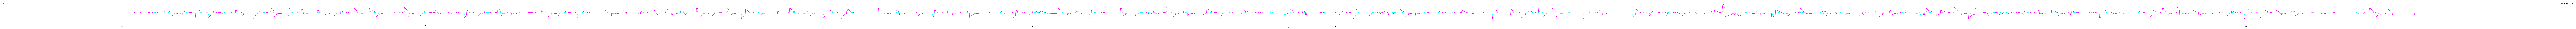

Vertical Saccades Plot


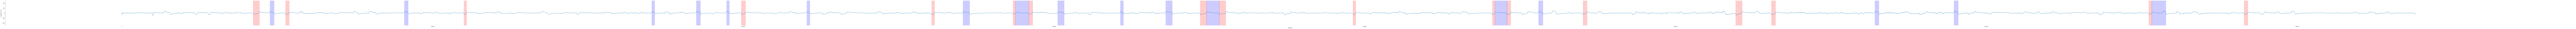

Vertical Saccades GroundTruth Plot


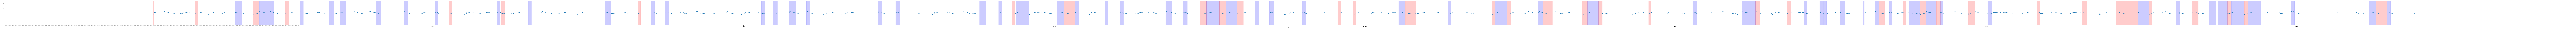

CWT Peaks Plot


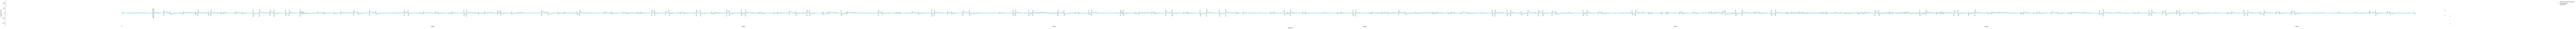

Horizontal Saccades Plot


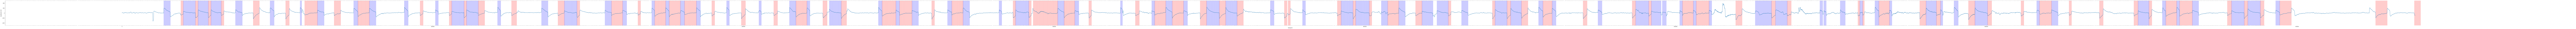

Horizontal Saccades GroundTruth Plot


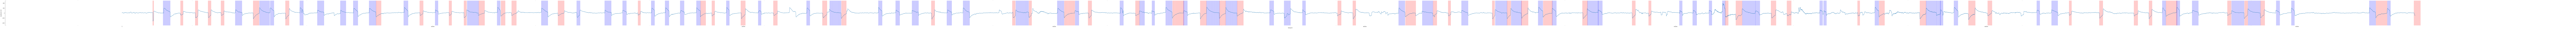

CWT Peaks Plot


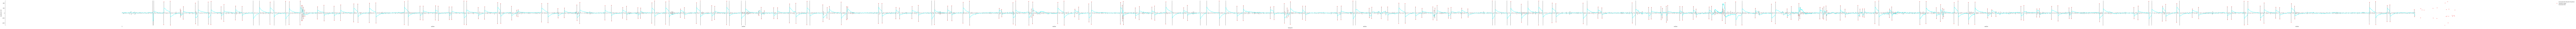

In [3]:
resultsPath = 'results/RI02_602/'
sectionName = 'WassimData'

verticalEOG, horizontalEOG = preProcessing.electrodesToVertHori(eyesData, 0, 1, 2, 3)

verticalEogDenoised = ndimage.median_filter(verticalEOG, size = 200)
horizontalEogDenoised = ndimage.median_filter(horizontalEOG, size = 200)

verticalEOG = verticalEogDenoised
horizontalEOG = horizontalEogDenoised

verticalEOG = databasePreparation.resampleSignal(verticalEOG, 1000, 2048)
horizontalEOG = databasePreparation.resampleSignal(horizontalEOG, 1000, 2048)

# verticalEOG = preProcessing.cutArtifacts(verticalEOG, 700)
# horizontalEOG = preProcessing.cutArtifacts(horizontalEOG, 700)

verticalEOG3 = np.reshape(verticalEOG, (len(verticalEOG),1))
horizontalEOG3 = np.reshape(horizontalEOG, (len(horizontalEOG),1))

coefVertMexHat, freqsVertMexHat = pywt.cwt(verticalEOG, 30, 'mexh')
coefHoriMexHat, freqsHoriMexHat = pywt.cwt(horizontalEOG, 30, 'mexh')

coefVertMexHat1 = np.reshape(coefVertMexHat, (len(coefVertMexHat[0]),1))
coefHoriMexHat1 = np.reshape(coefHoriMexHat, (len(coefHoriMexHat[0]),1))

#coefVertMexHat2 = preProcessing.zeroPadArtifacts(coefVertMexHat1, 70)

# Peakfinding

# Flatten the vectors so they can be used in the signal.find_peaks function
vertCwt = coefVertMexHat1.flatten()
horiCwt = coefHoriMexHat1.flatten()

# Thresholds of the saccade peaks
peaksHeight = np.array([90, 600])
minSaccadeDistance = 100

# Returns peaks' indexes and their properties in a dict
# The peaks are detected in the module version of signal in order to find the negative peaks as well
peaksV = findPeaks(vertCwt, peaksHeight[0], peaksHeight[1], minSaccadeDistance)
peaksH = findPeaks(horiCwt, peaksHeight[0], peaksHeight[1], minSaccadeDistance)

vertPeaksBinary = peaksToBinary(peaksV, vertCwt)
horiPeaksBinary = peaksToBinary(peaksH, horiCwt)

upSaccadeStartEnd, downSaccadeStartEnd = peaksBinarySaccadeAnalysis(vertPeaksBinary, jumpIntervalThreshold=500, saccadeLowerThreshold=500, saccadeUpperThreshold=8000)
leftSaccadeStartEnd, rightSaccadeStartEnd = peaksBinarySaccadeAnalysis(horiPeaksBinary, jumpIntervalThreshold=500, saccadeLowerThreshold=500, saccadeUpperThreshold=8000)

# Detecting saccades candidates and blink candidates
vertPeaksString = peaksBinaryToString(vertPeaksBinary[2])
horiPeaksString = peaksBinaryToString(horiPeaksBinary[2])

up, down, left, right, blinks = countEyeMovements(vertPeaksString, horiPeaksString)

# Reading the groundtruth for this file

saccadeGroundTruth = databasePreparation.loadNumpyArray('C:/Users/Ricardo/source/enac-eog-analysis/src/labelAnnotation/EOGLabel-main/sacTsWas1Dir.npy')
saccadeGroundTruth2 = databasePreparation.loadNumpyArray('C:/Users/Ricardo/source/enac-eog-analysis/src/labelAnnotation/EOGLabel-main/sacTsWas2Dir.npy')
saccadeGroundTruth3 = databasePreparation.loadNumpyArray('C:/Users/Ricardo/source/enac-eog-analysis/src/labelAnnotation/EOGLabel-main/saccadeTimeStamp.npy')
saccadeGroundTruth = saccadeGroundTruth.tolist()
saccadeGroundTruth2 = saccadeGroundTruth2.tolist()
saccadeGroundTruth3 = saccadeGroundTruth3.tolist()

up_correctSaccades, up_incorrectSaccades = evaluationUtils.saccadeEvaluation(upSaccadeStartEnd, 'up', saccadeGroundTruth3)
down_correctSaccades, down_incorrectSaccades = evaluationUtils.saccadeEvaluation(downSaccadeStartEnd, 'down', saccadeGroundTruth3)
left_correctSaccades, left_incorrectSaccades = evaluationUtils.saccadeEvaluation(leftSaccadeStartEnd, 'left', saccadeGroundTruth3)
right_correctSaccades, right_incorrectSaccades = evaluationUtils.saccadeEvaluation(rightSaccadeStartEnd, 'right', saccadeGroundTruth3)

#All the plots

print('Vertical and Horizontal Denoised signal Plot')
plotVertHorEOG(verticalEogDenoised, horizontalEogDenoised,  mode='both')
plt.show()

print('Vertical Saccades Plot')
plotSaccadeSpanInSignal(verticalEOG, upSaccadeStartEnd, downSaccadeStartEnd)
plt.show()

print('Vertical Saccades GroundTruth Plot')
plotSaccadeGTSpanInSignal(verticalEOG, saccadeGroundTruth3, 'vertical')
plt.show()

print('CWT Peaks Plot')
plotTransformAndPeaks(coefVertMexHat1, peaksV, verticalEOG, 'Vertical')
plt.show()

print('Horizontal Saccades Plot')
plotSaccadeSpanInSignal(horizontalEOG, leftSaccadeStartEnd, rightSaccadeStartEnd)
plt.show()

print('Horizontal Saccades GroundTruth Plot')
plotSaccadeGTSpanInSignal(horizontalEOG, saccadeGroundTruth3, 'horizontal')
plt.show()

print('CWT Peaks Plot')
plotTransformAndPeaks(coefHoriMexHat1, peaksH, horizontalEOG, 'Horizontal')
plt.show() 



 
 Correct Up Saccades: 12

 
 Incorrect Up Saccades: 0

 
 Correct Down Saccades: 11

 
 Incorrect Down Saccades: 0

 
 Correct Right Saccades: 57

 
 Incorrect Right Saccades: 0

 
 Correct left Saccades: 66

 
 Incorrect left Saccades: 0

 Number of saccades in the groundtruth:  161


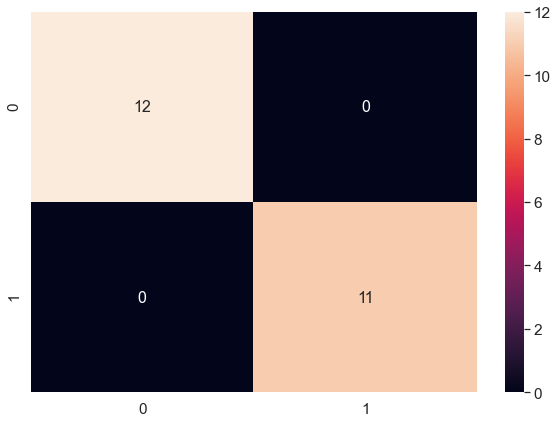

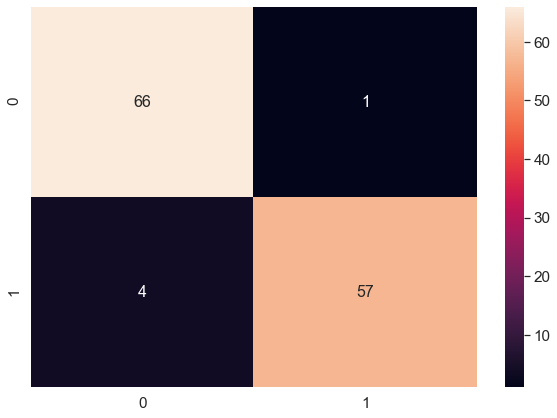

Precision:  0.73
Recall:  0.97
F1 Score: 0.83
False Positives (up, down, left, right:  5 6 21 23


In [4]:


up_correctSaccades, up_incorrectSaccades = evaluationUtils.saccadeEvaluation(upSaccadeStartEnd, 'up', saccadeGroundTruth3)
down_correctSaccades, down_incorrectSaccades = evaluationUtils.saccadeEvaluation(downSaccadeStartEnd, 'down', saccadeGroundTruth3)
left_correctSaccades, left_incorrectSaccades = evaluationUtils.saccadeEvaluation(leftSaccadeStartEnd, 'left', saccadeGroundTruth3)
right_correctSaccades, right_incorrectSaccades = evaluationUtils.saccadeEvaluation(rightSaccadeStartEnd, 'right', saccadeGroundTruth3)

print('\n \n Correct Up Saccades:', len(up_correctSaccades))
print('\n \n Incorrect Up Saccades:', len(up_incorrectSaccades))

print('\n \n Correct Down Saccades:', len(down_correctSaccades))
print('\n \n Incorrect Down Saccades:', len(down_incorrectSaccades))

print('\n \n Correct Right Saccades:', len(right_correctSaccades))
print('\n \n Incorrect Right Saccades:', len(right_incorrectSaccades))

print('\n \n Correct left Saccades:', len(left_correctSaccades))
print('\n \n Incorrect left Saccades:', len(left_incorrectSaccades))

print('\n Number of saccades in the groundtruth: ', len(saccadeGroundTruth3))

allDirSaccadeStartEnd = [upSaccadeStartEnd, downSaccadeStartEnd, leftSaccadeStartEnd, rightSaccadeStartEnd]
evaluationUtils.confusionMatrix(allDirSaccadeStartEnd, saccadeGroundTruth3)

[upSaccadeTP, upSaccadeFN, upSaccadeFP, downSaccadeTP, downSaccadeFN, downSaccadeFP, leftSaccadeTP,
     leftSaccadeFN, leftSaccadeFP, rightSaccadeTP, rightSaccadeFN, rightSaccadeFP] = evaluationUtils.saccadeConfusion(
        allDirSaccadeStartEnd, saccadeGroundTruth3)

